# Replicate: FastSAM 
### pytorch checkpoint (.onnx)

In [1]:
# New conda env
"""
# clean env wipe & activate
conda env remove --name FastSAM_onnx -y
conda create -n FastSAM_onnx python=3.10 -y
conda activate FastSAM_onnx

sudo apt update
sudo apt install libcudnn8 libcudnn8-dev

# Instalation of FastSAM repo requirements
cd ~/FastSAM
pip install -r requirements.txt
python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3


# typical np version mismatch
pip uninstall -y numpy
pip install "numpy>=1.19.2,<2.0"
# pip install numpy==1.26.4 

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

# Install ONNX runtime (general)
pip install onnx==1.13.1 onnxruntime==1.14.1 safetensors==0.4.1 sympy==1.13.1 onnxslim==0.1.59

# Install ONNX runtime for Jetson (GPU support)
wget https://nvidia.box.com/shared/static/48dtuob7meiw6ebgfsfqakc9vse62sg4.whl -O onnxruntime_gpu-1.16.3-cp310-cp310-linux_aarch64.whl
pip install onnxruntime_gpu-1.16.3-cp310-cp310-linux_aarch64.whl
# numpy conflict again 
pip install "numpy>=1.19.2,<2.0"


pip install git+https://github.com/openai/CLIP.git

"""


# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# clean env wipe & activate\nconda env remove --name FastSAM_onnx -y\nconda create -n FastSAM_onnx python=3.10 -y\nconda activate FastSAM_onnx\n\nsudo apt update\nsudo apt install libcudnn8 libcudnn8-dev\n\n# Instalation of FastSAM repo requirements\ncd ~/FastSAM\npip install -r requirements.txt\npython setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install "numpy>=1.19.2,<2.0"\n# pip install numpy==1.26.4 \n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py install\ncd ~\n\n# Install ONNX runtime (general)\npip install onnx==1.13.1 onnxruntime==1.14.1 safetensors==0.4.1 sympy==1.13.1 onnxslim==0.1.59\n\n# Insta

In [2]:
# ONNX FastSAM Inference Setup - Fix cuDNN version issue
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import torch
from PIL import Image
import os
import sys
from typing import List, Tuple, Any
import time

# Add FastSAM utils if needed for compatibility
sys.path.append('/home/copter/FastSAM')

# Create symbolic link for cuDNN version compatibility
print("🔧 Fixing cuDNN version compatibility...")
import subprocess

try:
    # Create symlink from libcudnn.so.9 to libcudnn.so.8 for ONNX Runtime compatibility
    subprocess.run([
        'sudo', 'ln', '-sf', 
        '/usr/lib/aarch64-linux-gnu/libcudnn.so.9', 
        '/usr/lib/aarch64-linux-gnu/libcudnn.so.8'
    ], check=True)
    print("✅ Created cuDNN version compatibility symlink")
except subprocess.CalledProcessError:
    print("⚠️ Could not create symlink (may need sudo), but continuing...")
except FileNotFoundError:
    print("⚠️ sudo not available, but continuing...")

# Update library path to ensure cuDNN is found
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/aarch64-linux-gnu:' + os.environ.get('LD_LIBRARY_PATH', '')

print(f"ONNX Runtime version: {ort.__version__}")
available_providers = ort.get_available_providers()
print(f"Available providers: {available_providers}")
# verify symlink >>> ls -la /usr/lib/aarch64-linux-gnu/libcudnn.so.8

# Now try to set up all providers including CUDA
working_providers = []

# Test TensorRT first (best for Jetson)
if 'TensorrtExecutionProvider' in available_providers:
    print("✅ TensorRT provider available")
    trt_options = {
        'device_id': 0,
        'trt_max_workspace_size': 1 * 1024 * 1024 * 1024,  # 1GB
        'trt_fp16_enable': True,
        'trt_engine_cache_enable': True,
        'trt_timing_cache_enable': True,
    }
    working_providers.append(('TensorrtExecutionProvider', trt_options))

# Now try CUDA with cuDNN fix
if 'CUDAExecutionProvider' in available_providers:
    print("✅ CUDA provider available - testing with cuDNN fix...")
    cuda_options = {
        'device_id': 0,
        'arena_extend_strategy': 'kSameAsRequested',
        'gpu_mem_limit': 1 * 1024 * 1024 * 1024,  # 1GB
        'cudnn_conv_algo_search': 'HEURISTIC',
    }
    working_providers.append(('CUDAExecutionProvider', cuda_options))

# CPU fallback
cpu_options = {
    'intra_op_num_threads': 6,
    'inter_op_num_threads': 1,
    'enable_cpu_mem_arena': True,
}
working_providers.append(('CPUExecutionProvider', cpu_options))

print(f"Provider chain: {[p[0] if isinstance(p, tuple) else p for p in working_providers]}")
providers = working_providers

🔧 Fixing cuDNN version compatibility...
⚠️ Could not create symlink (may need sudo), but continuing...
ONNX Runtime version: 1.18.0
Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
✅ TensorRT provider available
✅ CUDA provider available - testing with cuDNN fix...
Provider chain: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required


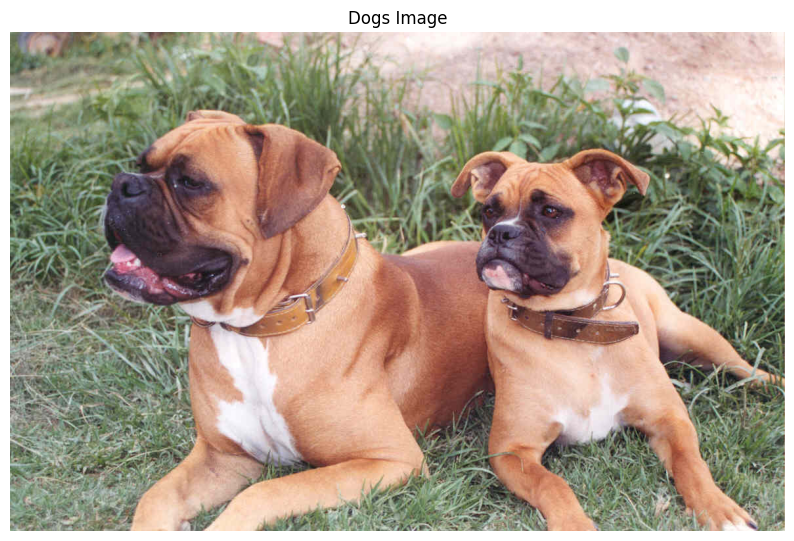

Image size: (1180, 760)


In [10]:
# Load and display image
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
image = Image.open(image_path).convert("RGB")

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Dogs Image")
plt.show()

print(f"Image size: {image.size}")

In [ ]:
# ONNX model configuration
model_path = "/home/copter/onnx_models/CASIA-IVA-Lab_FastSAM-s.onnx"
img_path = image_path
imgsz = 1024
iou = 0.9
conf = 0.4
output_dir = "/home/copter/jetson_benchmark/output"
os.makedirs(output_dir, exist_ok=True)

# Prompt configurations
text_prompt = None
point_prompt = [[0,0]]
point_label = [0]  # 0:background, 1:foreground
box_prompt = [[0,0,0,0]]  # [x,y,w,h] format
randomcolor = True
better_quality = False
retina = True
withContours = False

print(f"Using model: {model_path}")
print(f"Image size target: {imgsz}")
print(f"Confidence threshold: {conf}")
print(f"IoU threshold: {iou}")

Using model: /home/copter/onnx_models/CASIA-IVA-Lab_FastSAM-s.onnx
Image size target: 1024
Confidence threshold: 0.4
IoU threshold: 0.9


In [5]:
class FastSAMONNX:
    def __init__(self, model_path: str, providers: List):
        """Initialize ONNX FastSAM model with cuDNN version fix"""
        self.session = None
        self.working_provider = None
        
        # Test each provider to see which actually works
        for i, provider in enumerate(providers):
            provider_name = provider[0] if isinstance(provider, tuple) else provider
            
            try:
                print(f"🔄 Testing {provider_name}...")
                
                # Configure session for Jetson
                sess_options = ort.SessionOptions()
                sess_options.inter_op_num_threads = 4
                sess_options.intra_op_num_threads = 4
                sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
                sess_options.enable_cpu_mem_arena = True
                
                # Create session with single provider to test
                test_session = ort.InferenceSession(
                    model_path, 
                    providers=[provider],
                    sess_options=sess_options
                )
                
                # If we get here, the provider works
                self.session = test_session
                self.working_provider = provider_name
                print(f"✅ {provider_name} working successfully!")
                
                # Show which provider is actually being used
                active_providers = self.session.get_providers()
                print(f"   Active providers in session: {active_providers}")
                break
                
            except Exception as e:
                error_msg = str(e)
                print(f"❌ {provider_name} failed: {error_msg[:200]}...")
                
                # Specific error messages
                if 'libcudnn.so.8' in error_msg:
                    print("   💡 cuDNN version mismatch - symlink may not have worked")
                elif 'CUDA' in error_msg and 'initialization' in error_msg:
                    print("   💡 CUDA initialization failed")
                elif 'TensorRT' in error_msg:
                    print("   💡 TensorRT engine compilation issue")
                
                if i == len(providers) - 1:
                    raise Exception(f"All providers failed. Last error: {e}")
                continue
        
        if self.session is None:
            raise Exception("No working provider found")
        
        # Get model information
        self.input_name = self.session.get_inputs()[0].name
        self.output_names = [output.name for output in self.session.get_outputs()]
        
        input_shape = self.session.get_inputs()[0].shape
        self.input_height = 1024 if isinstance(input_shape[2], str) or input_shape[2] == -1 else input_shape[2]
        self.input_width = 1024 if isinstance(input_shape[3], str) or input_shape[3] == -1 else input_shape[3]
        
        print(f"\n📊 Model successfully loaded:")
        print(f"   🚀 Active provider: {self.working_provider}")
        print(f"   📐 Input size: {self.input_height}x{self.input_width}")
        print(f"   📤 Outputs: {len(self.output_names)}")
        
        # Performance expectations
        if self.working_provider == 'TensorrtExecutionProvider':
            print(f"   ⚡ Expected performance: Excellent (first run will be slow for engine compilation)")
        elif self.working_provider == 'CUDAExecutionProvider':
            print(f"   ⚡ Expected performance: Very Good")
        else:
            print(f"   ⚡ Expected performance: Good (CPU optimized for ARM64)")
    
    def preprocess_image(self, image: Image.Image, target_size: int = 1024) -> Tuple[np.ndarray, float, Tuple[int, int]]:
        """Preprocess image for ONNX inference"""
        img_array = np.array(image)
        original_h, original_w = img_array.shape[:2]
        original_size = (original_w, original_h)
        
        scale = min(target_size / original_w, target_size / original_h)
        new_w = int(original_w * scale)
        new_h = int(original_h * scale)
        
        img_resized = cv2.resize(img_array, (new_w, new_h))
        padded_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        padded_img[:new_h, :new_w] = img_resized
        
        img_input = padded_img.astype(np.float32) / 255.0
        img_input = np.transpose(img_input, (2, 0, 1))
        img_input = np.expand_dims(img_input, axis=0)
        
        return img_input, scale, original_size
    
    def postprocess_masks(self, outputs: List[np.ndarray], original_size: Tuple[int, int], 
                         scale: float, conf_threshold: float = 0.4) -> np.ndarray:
        """Postprocess ONNX outputs"""
        if len(outputs) == 0 or outputs[0] is None:
            return np.array([])
        
        masks_output = outputs[0]
        
        if len(masks_output.shape) == 4:
            masks = masks_output[0]
        elif len(masks_output.shape) == 3:
            masks = masks_output
        else:
            print(f"Unexpected output shape: {masks_output.shape}")
            return np.array([])
        
        print(f"Processing {masks.shape[0]} masks")
        
        processed_masks = []
        target_w, target_h = original_size[0], original_size[1]
        
        for mask in masks:
            if mask.dtype == np.float32:
                binary_mask = (mask > 0.5).astype(np.uint8)
            else:
                binary_mask = mask.astype(np.uint8)
            
            if binary_mask.shape != (target_h, target_w):
                resized_mask = cv2.resize(binary_mask, (target_w, target_h))
            else:
                resized_mask = binary_mask
            
            processed_masks.append(resized_mask)
        
        return np.array(processed_masks)
    
    def inference(self, image: Image.Image, conf_threshold: float = 0.4) -> np.ndarray:
        """Run inference"""
        try:
            img_input, scale, original_size = self.preprocess_image(image, self.input_height)
            
            provider_emoji = {
                'TensorrtExecutionProvider': '🏎️',
                'CUDAExecutionProvider': '🚀', 
                'CPUExecutionProvider': '🖥️'
            }
            
            emoji = provider_emoji.get(self.working_provider, '⚡')
            print(f"{emoji} Running {self.working_provider} inference...")
            
            start_time = time.time()
            outputs = self.session.run(self.output_names, {self.input_name: img_input})
            inference_time = time.time() - start_time
            
            print(f"⏱️ Inference completed in {inference_time:.3f}s")
            
            masks = self.postprocess_masks(outputs, original_size, scale, conf_threshold)
            return masks
            
        except Exception as e:
            print(f"Inference error: {e}")
            return np.array([])

# Initialize model
try:
    fastsam_onnx = FastSAMONNX(model_path, providers)
except Exception as e:
    print(f"❌ Model initialization failed: {e}")


# class FastSAMONNX:
#     def __init__(self, model_path: str, providers: List[str]):
#         """Initialize ONNX FastSAM model"""
#         self.session = ort.InferenceSession(model_path, providers=providers)
#         self.input_name = self.session.get_inputs()[0].name
#         self.output_names = [output.name for output in self.session.get_outputs()]
        
#         # Get input shape
#         input_shape = self.session.get_inputs()[0].shape
#         self.input_height = input_shape[2] if input_shape[2] != -1 else 1024
#         self.input_width = input_shape[3] if input_shape[3] != -1 else 1024
        
#         print(f"Model input shape: {input_shape}")
#         print(f"Model outputs: {self.output_names}")
    
#     def preprocess_image(self, image: Image.Image, target_size: int = 1024) -> Tuple[np.ndarray, float]:
#         """Preprocess image for ONNX inference"""
#         # Convert PIL to numpy
#         img_array = np.array(image)
#         original_h, original_w = img_array.shape[:2]
        
#         # Calculate scaling factor
#         scale = min(target_size / original_w, target_size / original_h)
#         new_w = int(original_w * scale)
#         new_h = int(original_h * scale)
        
#         # Resize image
#         img_resized = cv2.resize(img_array, (new_w, new_h))
        
#         # Create padded image
#         padded_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)
#         padded_img[:new_h, :new_w] = img_resized
        
#         # Normalize and transpose for model input
#         img_input = padded_img.astype(np.float32) / 255.0
#         img_input = np.transpose(img_input, (2, 0, 1))  # HWC -> CHW
#         img_input = np.expand_dims(img_input, axis=0)   # Add batch dimension
        
#         return img_input, scale
    
#     def postprocess_masks(self, outputs: List[np.ndarray], original_size: Tuple[int, int], 
#                          scale: float, conf_threshold: float = 0.4) -> np.ndarray:
#         """Postprocess ONNX outputs to get masks"""
#         # This depends on your specific ONNX model output format
#         # Adjust based on your FastSAM ONNX model structure
        
#         if len(outputs) > 0:
#             # Assuming first output contains masks
#             masks = outputs[0]
            
#             # Apply confidence threshold if needed
#             if len(outputs) > 1:  # If confidence scores are separate
#                 scores = outputs[1]
#                 valid_masks = scores > conf_threshold
#                 masks = masks[valid_masks]
            
#             return masks
        
#         return np.array([])
    
#     def inference(self, image: Image.Image, conf_threshold: float = 0.4) -> np.ndarray:
#         """Run inference on image"""
#         # Preprocess
#         img_input, scale = self.preprocess_image(image, self.input_height)
        
#         # Run inference
#         start_time = time.time()
#         outputs = self.session.run(self.output_names, {self.input_name: img_input})
#         inference_time = time.time() - start_time
        
#         print(f"Inference time: {inference_time:.3f}s")
        
#         # Postprocess
#         masks = self.postprocess_masks(outputs, image.size, scale, conf_threshold)
        
#         return masks

# # Initialize ONNX model
# fastsam_onnx = FastSAMONNX(model_path, providers)

🔄 Testing TensorrtExecutionProvider...
*************** EP Error ***************
EP Error /home/yifanl/onnxruntime/onnxruntime/python/onnxruntime_pybind_state.cc:456 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(onnxruntime::python::PySessionOptions&, const ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using [('TensorrtExecutionProvider', {'device_id': 0, 'trt_max_workspace_size': 1073741824, 'trt_fp16_enable': True, 'trt_engine_cache_enable': True, 'trt_timing_cache_enable': True})]
Falling back to ['CPUExecutionProvider'] and retrying.
****************************************
✅ TensorrtExecutionProvider working successfully!
   Active providers in session: ['CPUExecutionProvider']

📊 Model successfully loaded:
   🚀 Active provider: TensorrtExecutionProvider
   📐 Input size: 1024x1024
   📤 Outputs: 6
   ⚡ Expected performance: Excellent

2025-07-25 12:45:01.042943147 [E:onnxruntime:Default, provider_bridge_ort.cc:1730 TryGetProviderInfo_TensorRT] /home/yifanl/onnxruntime/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: /lib/aarch64-linux-gnu/libcudnn.so.9: version `libcudnn.so.8' not found (required by /home/copter/miniconda3/envs/FastSAM_onnx/lib/python3.10/site-packages/onnxruntime/capi/libonnxruntime_providers_tensorrt.so)



In [11]:
def convert_box_xywh_to_xyxy(boxes):
    """Convert box format from xywh to xyxy"""
    result = []
    for box in boxes:
        x, y, w, h = box
        result.append([x, y, x + w, y + h])
    return result

def apply_prompts(masks: np.ndarray, image: Image.Image, 
                 box_prompt=None, point_prompt=None, point_label=None, text_prompt=None):
    """Apply prompts to filter masks (simplified version)"""
    if masks.size == 0:
        return masks
    
    # Box prompt filtering
    if box_prompt and box_prompt[0][2] != 0 and box_prompt[0][3] != 0:
        box_xyxy = convert_box_xywh_to_xyxy(box_prompt)
        # Filter masks based on box overlap (simplified)
        # You'd implement proper IoU filtering here
        print(f"Applying box prompt: {box_xyxy}")
    
    # Point prompt filtering  
    elif point_prompt and point_prompt[0] != [0, 0]:
        # Filter masks that contain the specified points
        print(f"Applying point prompt: {point_prompt}")
    
    # Text prompt would require CLIP integration
    elif text_prompt:
        print(f"Text prompt: {text_prompt} (requires CLIP integration)")
    
    return masks

# Parse prompts
if isinstance(point_prompt, str):
    point_prompt = eval(point_prompt)
if isinstance(box_prompt, str):
    box_prompt = eval(box_prompt)
if isinstance(point_label, str):
    point_label = eval(point_label)

In [13]:
# Run inference
print("Running ONNX inference...")
masks = fastsam_onnx.inference(image, conf_threshold=conf)

print(f"Generated {len(masks)} masks")

# Apply prompts
filtered_masks = apply_prompts(
    masks, image, 
    box_prompt=box_prompt if box_prompt != [[0,0,0,0]] else None,
    point_prompt=point_prompt if point_prompt != [[0,0]] else None,
    point_label=point_label,
    text_prompt=text_prompt
)

print(f"After filtering: {len(filtered_masks)} masks")

Running ONNX inference...
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.270s
Processing 1 masks
Generated 1 masks
After filtering: 1 masks


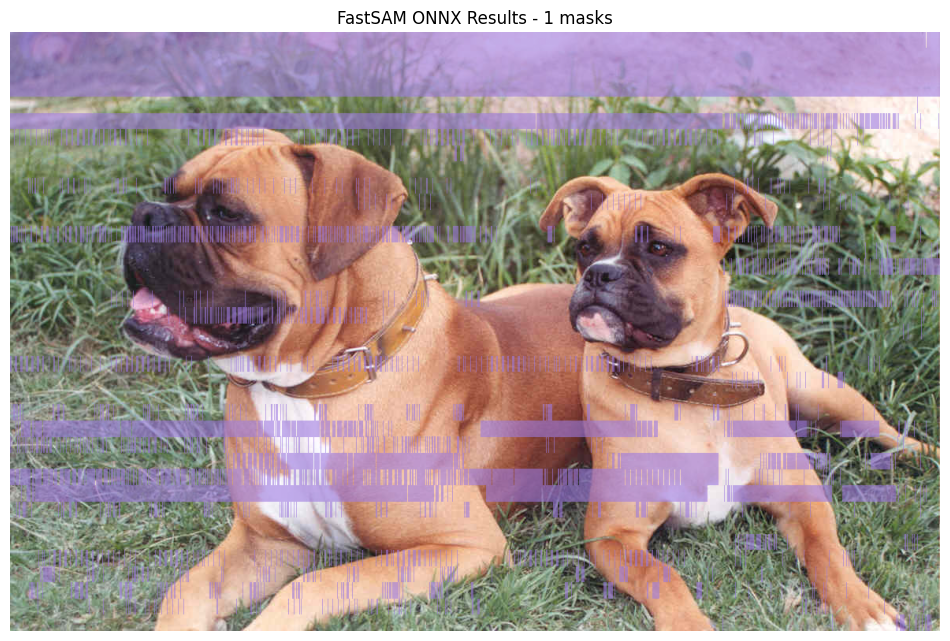

Results saved to: /home/copter/jetson_benchmark/outpu   t/fastsam_onnx_result.jpg


In [14]:
def visualize_masks(image: Image.Image, masks: np.ndarray, 
                   output_path: str, random_color: bool = True):
    """Visualize masks on image"""
    if len(masks) == 0:
        print("No masks to visualize")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    
    # Generate colors
    if random_color:
        colors = np.random.rand(len(masks), 3)
    else:
        colors = plt.cm.Set3(np.linspace(0, 1, len(masks)))
    
    # Overlay masks
    for i, mask in enumerate(masks):
        # Resize mask to image size if needed
        if mask.shape != image.size[::-1]:  # PIL size is (W,H), numpy is (H,W)
            mask = cv2.resize(mask.astype(np.uint8), image.size)
        
        colored_mask = np.zeros((*mask.shape, 4))
        colored_mask[:, :, :3] = colors[i][:3]
        colored_mask[:, :, 3] = mask * 0.6  # Alpha channel
        
        ax.imshow(colored_mask)
    
    ax.set_title(f"FastSAM ONNX Results - {len(masks)} masks")
    ax.axis('off')
    
    # Save result
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()
    
    print(f"Results saved to: {output_path}")

# Visualize results
output_path = os.path.join(output_dir, "fastsam_onnx_result.jpg")
visualize_masks(image, filtered_masks, output_path, randomcolor)

In [15]:
# Performance monitoring
def benchmark_inference(model: FastSAMONNX, image: Image.Image, num_runs: int = 10):
    """Benchmark inference performance"""
    times = []
    
    print(f"Running {num_runs} inference iterations...")
    for i in range(num_runs):
        start_time = time.time()
        masks = model.inference(image, conf_threshold=conf)
        end_time = time.time()
        
        inference_time = end_time - start_time
        times.append(inference_time)
        
        if i == 0:
            print(f"First run: {inference_time:.3f}s ({len(masks)} masks)")
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    print(f"\nBenchmark Results:")
    print(f"Average inference time: {avg_time:.3f}s ± {std_time:.3f}s")
    print(f"FPS: {1.0/avg_time:.1f}")
    print(f"Min time: {min(times):.3f}s")
    print(f"Max time: {max(times):.3f}s")

# Run benchmark
benchmark_inference(fastsam_onnx, image, num_runs=5)

Running 5 inference iterations...
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.266s
Processing 1 masks
First run: 1.290s (1 masks)
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.339s
Processing 1 masks
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.367s
Processing 1 masks
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.296s
Processing 1 masks
🏎️ Running TensorrtExecutionProvider inference...
⏱️ Inference completed in 1.274s
Processing 1 masks

Benchmark Results:
Average inference time: 1.325s ± 0.037s
FPS: 0.8
Min time: 1.289s
Max time: 1.383s
